First we are going to import all the libraries we need

In [18]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

Now we are going to load the datset

In [19]:
filepath = '/Users/ritika/Downloads/GNN-Tutorial-main/'
dataset_path = filepath+'simulator_data.csv'

# Load the dataset
data = pd.read_csv(dataset_path)

Now we will implement some basic helper functions that we need

In [20]:
# Function to compute the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [21]:
# Function to check for handovers between timestamps
def check_handovers(df, current_timestamp, next_timestamp):
    current_data = df[df['timestamp'] == current_timestamp]
    next_data = df[df['timestamp'] == next_timestamp]

    handovers = {}
    for vid in current_data['vehicleId'].unique():
        current_master = current_data[current_data['vehicleId'] == vid]['masterId'].iloc[0]
        next_master = next_data[next_data['vehicleId'] == vid]['masterId'].iloc[0] if vid in next_data['vehicleId'].values else current_master
        handovers[vid] = current_master != next_master

    return handovers

Lets create our Graph

In [22]:
# Function to create a graph data object and NetworkX graph for a given timestamp
def create_graph_data_for_timestamp(df, timestamp):
    timestamp_data = df[df['timestamp'] == timestamp]
    vehicle_ids = timestamp_data['vehicleId'].unique()
    #print('number of vehicles:', vehicle_ids.size)
    tower_ids = timestamp_data['towerId'].unique()
    #print('number of towers:', tower_ids.size)
    vehicle_mapping = {vid: i for i, vid in enumerate(vehicle_ids)}
    tower_mapping = {tid: i + len(vehicle_ids) for i, tid in enumerate(tower_ids)}

    node_features = []
    edge_index = []
    edge_features = []

    G = nx.Graph()  # NetworkX Graph for visualization

    # Process vehicle nodes
    for vid in vehicle_ids:
        try:
            vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[2]
        except IndexError:
            try:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[1]
            except IndexError:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_features = [
            vehicle_data['vehicleSpeed'], vehicle_data['vehicleDirection'], vehicle_data['vehiclePosX'],
            vehicle_data['vehiclePosY']
        ]
        node_features.append(vehicle_features)
        G.add_node(vehicle_mapping[vid], speed=vehicle_data['vehicleSpeed'], dir=vehicle_data['vehicleDirection'], 
                  pos=(vehicle_data['vehiclePosX'], vehicle_data['vehiclePosY']),
                   type='vehicle', label=f'{vid}')

    # Process tower nodes
    for tid in tower_ids:
        master_data = timestamp_data[timestamp_data['masterId'] == tid][::-1]
        if not master_data.empty:
            tower_data = master_data.iloc[0]
            tower_features = [
                tower_data['masterPosX'], tower_data['masterPosY'],
                tower_data['masterLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['masterPosX'], tower_data['masterPosY']), load=tower_data['masterLoad'],
                    type='tower', label=f'T{tid}')
        else:
            tower_data = timestamp_data[timestamp_data['towerId'] == tid][::-1].iloc[0]
            tower_features = [
                tower_data['towerPosX'], tower_data['towerPosY'],
                tower_data['towerLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['towerPosX'], tower_data['towerPosY']), load=tower_data['towerLoad'],
                        type='tower', label=f'T{tid}')

        node_features.append(tower_features)
        

    # Add edges based on the masterId
    for _, row in timestamp_data.iterrows():
        vehicle_id = vehicle_mapping[row['vehicleId']]
        tower_id = tower_mapping[row['masterId']]  # Connect to the master tower
        edge_index.append([vehicle_id, tower_id])
        

        distance = calculate_distance(row['vehiclePosX'], row['vehiclePosY'],
                                      row['masterPosX'], row['masterPosY'])
        edge_features.append([row['throughput'], row['masterRssi'], distance])

        # Add edges to the NetworkX graph
        G.add_edge(vehicle_id, tower_id, throughput=row['throughput'],  rssi=row['masterRssi'], distance=distance)
    
    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # print(edge_index_tensor)
    # print(len(edge_index))
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)
    #print("node features: ", graph_data.x.shape,"edge index: ", graph_data.edge_index.shape,"edge attr: ", graph_data.edge_attr.shape)
    return graph_data, G, vehicle_mapping, tower_mapping

Graph Visualization

In [23]:
# Visualization function
def visualize_graph(G, handovers, vehicle_mapping, tower_mapping):
    # Set node attributes for vehicle and tower IDs and colors
    for node in G.nodes:
        node_info = G.nodes[node]
        node_type = node_info['type']
        if node_type == 'vehicle':
            label = node_info['label']
            color = 'lightblue'  # Color for vehicles
        elif node_type == 'tower':
            label = node_info['label']
            color = 'lightgreen'  # Color for towers
        else:
            label = 'Unknown'
            color = 'gray'

        G.nodes[node]['label'] = label
        G.nodes[node]['color'] = color

    # Highlight handover nodes
    for vehicle_id, handover in handovers.items():
        if handover:
            node = vehicle_mapping.get(vehicle_id)
            if node is not None:
                G.nodes[node]['color'] = 'lightpink'  # Highlight color for handovers

    # Set edge attributes for master RSSI
    for u, v in G.edges:
        edge_data = G[u][v]
        # Ensure that the 'masterRssi' key is correctly named as per your data
        master_rssi = edge_data.get('rssi', 0.0)  # Default to 'N/A' if not available
        G.edges[u, v]['label'] = str(int(master_rssi))

    # Prepare colors for nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes]

    # Visualize the graph
    pos = nx.get_node_attributes(G, 'pos')
    scale_factor = 100
    # Scale the x and y coordinates of each node
    scaled_pos = {node: (x * scale_factor, y * scale_factor) for node, (x, y) in pos.items()}
    nx.set_node_attributes(G, scaled_pos, 'pos')

    nx.draw(G, pos=scaled_pos, node_color=node_colors, with_labels=True, labels=nx.get_node_attributes(G, 'label'),font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos=scaled_pos, edge_labels=nx.get_edge_attributes(G, 'label'),font_size=8)

    
def visualize_for_timestamp_range(df, start_timestamp, end_timestamp=None):
    if end_timestamp is not None:
        # Visualize graphs for the specified range
        timestamps = df['timestamp'].unique()
        timestamps_in_range = [t for t in timestamps if start_timestamp <= t <= end_timestamp]

        for timestamp in timestamps_in_range:
            # Get the next timestamp in the sequence for handover comparison
            next_timestamp_index = np.where(timestamps == timestamp)[0][0] + 1
            if next_timestamp_index < len(timestamps):
                next_timestamp = timestamps[next_timestamp_index]
            else:
                next_timestamp = timestamp  # No handover if it's the last timestamp

            # Check for handovers and create the graph for the current timestamp
            handovers = check_handovers(df, timestamp, next_timestamp)
            _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, timestamp)

            # Visualize the graph
            plt.figure(figsize=(12, 8))
            visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
            plt.title(f'Network Graph at Timestamp {timestamp}')
            plt.show()
    else:
        # Visualize a single graph for start_timestamp to start_timestamp + 0.5
        _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, start_timestamp)   
        handovers = check_handovers(df, start_timestamp, start_timestamp + 0.5) 
        plt.figure(figsize=(12, 8))
        visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
        plt.title(f'Network Graph at Timestamp {start_timestamp}')
        plt.show()

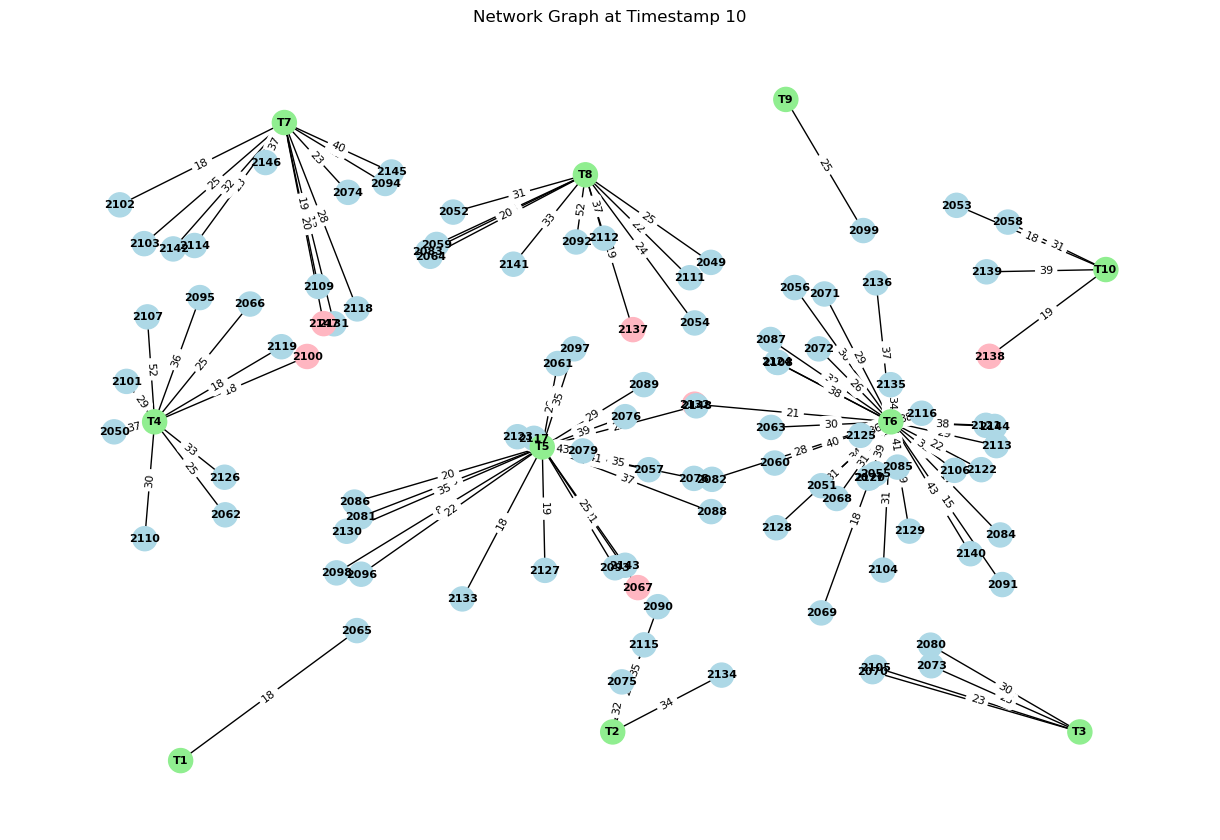

In [24]:
visualize_for_timestamp_range(data, start_timestamp=10)

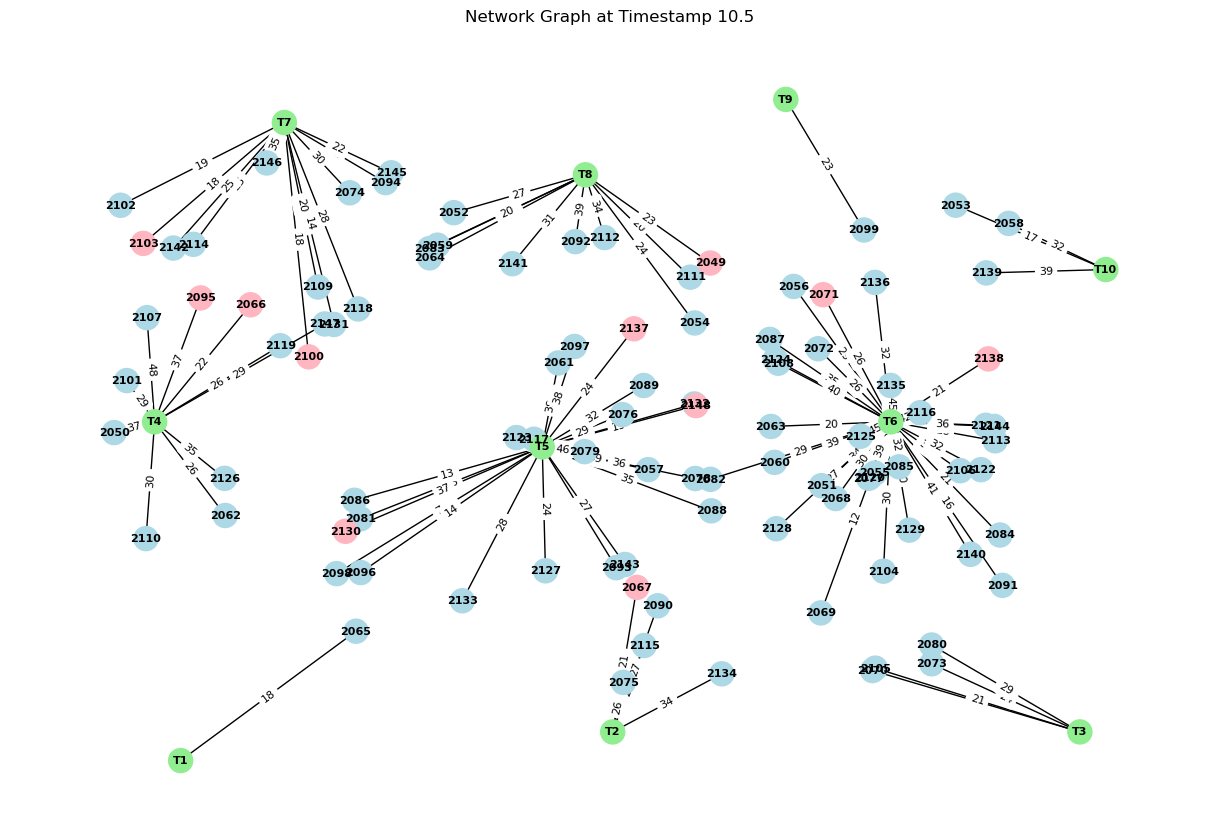

In [25]:
visualize_for_timestamp_range(data, start_timestamp=10.5)

Building GNN model

In [26]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)  # Include edge_index here
        return x

Loss Function

In [27]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

In [28]:
import random

def get_triplets(data, embeddings, vehicle_mapping, tower_mapping):
    anchors = []
    positives = []
    negatives = []

    # print(data.edge_index)
    for vehicle_id in vehicle_mapping.values():
        # vehicle_idx = vehicle_mapping[vehicle_id]
        # print(vehicle_idx)

        # Get the indices of towers connected to this vehicle (positive samples)
        # connected_towers = [tower_mapping[tid] for tid in data.edge_index[1][data.edge_index[0] == vehicle_idx].tolist()]
        connected_towers = data.edge_index[1][data.edge_index[0] == vehicle_id].tolist()

        if not connected_towers:
            continue

        # Select one connected tower as positive
        positive_idx = random.choice(connected_towers)

        # Select one non-connected tower as negative
        non_connected_towers = list(set(tower_mapping.values()) - set(connected_towers))
        if not non_connected_towers:
            continue
        negative_idx = random.choice(non_connected_towers)

        anchors.append(embeddings[vehicle_id])
        positives.append(embeddings[positive_idx])
        negatives.append(embeddings[negative_idx])

    # Convert to tensors
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)

    return anchors, positives, negatives

Training the model

In [29]:
train_time = 10
test_time = 10.5

#train_data = data[data['timestamp'] <= train_time]
#train_data = data[data['timestamp'] == train_time]
#test_data = data[data['timestamp'] == test_time]

#train_graphs = [create_graph_data_for_timestamp(train_data, ts) for ts in train_data['timestamp'].unique()]
train_graph_data, train_G, train_vehicle_mapping, train_tower_mapping = create_graph_data_for_timestamp(data,train_time)
#test_graphs = [create_graph_data_for_timestamp(test_data, ts) for ts in test_data['timestamp'].unique()]
test_graph_data, test_G, test_vehicle_mapping, test_tower_mapping = create_graph_data_for_timestamp(data,test_time)

In [30]:
# Create a DataLoader
train_loader = DataLoader([train_graph_data], batch_size=32, shuffle=True)
test_loader = DataLoader([test_graph_data], batch_size=32)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_node_features=train_graph_data.num_node_features, hidden_channels=64, out_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    total_loss = 0
    for data in train_loader:
        # print(data)
        data = data.to(device)
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)
        # print(embeddings.shape)

        anchors, positives, negatives = get_triplets(data, embeddings, train_vehicle_mapping, train_tower_mapping)
        loss = triplet_loss(anchors, positives, negatives)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #print(epoch)

    #print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

Epoch 1, Loss: 140885472.0
Epoch 2, Loss: 61867024.0
Epoch 3, Loss: 27329856.0
Epoch 4, Loss: 14383036.0
Epoch 5, Loss: 9102902.0
Epoch 6, Loss: 10775313.0
Epoch 7, Loss: 9555597.0
Epoch 8, Loss: 10828526.0
Epoch 9, Loss: 10380750.0
Epoch 10, Loss: 8617160.0
Epoch 11, Loss: 8700168.0
Epoch 12, Loss: 6585855.5
Epoch 13, Loss: 5317126.0
Epoch 14, Loss: 4954104.0
Epoch 15, Loss: 4329638.5
Epoch 16, Loss: 3061209.0
Epoch 17, Loss: 2785208.25
Epoch 18, Loss: 2283281.5
Epoch 19, Loss: 1647778.125
Epoch 20, Loss: 1506018.875
Epoch 21, Loss: 1189520.375
Epoch 22, Loss: 1157264.625
Epoch 23, Loss: 838347.9375
Epoch 24, Loss: 794304.9375
Epoch 25, Loss: 678989.1875
Epoch 26, Loss: 705576.875
Epoch 27, Loss: 614102.75
Epoch 28, Loss: 735884.8125
Epoch 29, Loss: 689211.625
Epoch 30, Loss: 548077.125
Epoch 31, Loss: 444847.03125
Epoch 32, Loss: 465136.53125
Epoch 33, Loss: 460600.8125
Epoch 34, Loss: 459919.125
Epoch 35, Loss: 447062.25
Epoch 36, Loss: 322963.46875
Epoch 37, Loss: 313376.03125
Epoc

Getting the top towers for handover

In [32]:
vehicle_indices = list(train_vehicle_mapping.values())
tower_indices = list(train_tower_mapping.values())

vehicle_embeddings = embeddings[vehicle_indices]
tower_embeddings = embeddings[tower_indices]

# Convert PyTorch tensors to NumPy arrays using detach().numpy()
vehicle_embeddings = vehicle_embeddings.detach().numpy()
tower_embeddings = tower_embeddings.detach().numpy()
# print(vehicle_embeddings)

# Calculate cosine similarity between each vehicle and all towers
similarity_matrix = cosine_similarity(vehicle_embeddings, tower_embeddings)

top_3_candidates = {}
for i, vehicle_id in enumerate(train_vehicle_mapping.keys()):
    # Get indices of top 3 towers based on similarity
    top_towers_indices = np.argsort(similarity_matrix[i])[::-1][:3]
    
    #print(f'Vehicle {vehicle_id} top handover for next timestamp will be {top_towers_indices}')
    # Map indices back to tower IDs
    # print(top_towers_indices)
    # top_towers_ids = [list(tower_mapping.keys())[list(tower_mapping.keys()).index(idx)] for idx in top_towers_indices]

    top_3_candidates[vehicle_id] = top_towers_indices


Testing the model so far

In [33]:
def calculate_accuracy(preds, true):
    correct = 0
    for pred, truth in zip(preds, true):
        if pred[0] == truth or pred[1] == truth or pred[2] == truth:
            correct += 1
    return correct / len(true)

In [34]:
edgeF = train_graph_data.edge_index.numpy()
def evaluate_model():
    predictions = []
    ground_truths = []

    

    for vehicle, vehicle_id in test_vehicle_mapping.items():
        best_tower_predicted = top_3_candidates[vehicle]
        predictions.append(best_tower_predicted)

        # Assuming you have a way to get the ground truth best tower 
        best_tower_actual = edgeF[1][vehicle_id]
        for tower, tower_id in train_tower_mapping.items():
            if tower_id == best_tower_actual:
                best_tower_actual = tower
                break
        ground_truths.append(best_tower_actual)

    accuracy = calculate_accuracy(predictions, ground_truths)
    return accuracy

In [35]:
ev = evaluate_model()
print(ev)

0.26
